In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [25]:
df = pd.read_csv(r"D:\PYTON PROGRAMMING\PYTHON FILES\Scikit-Learn\PROJECT\CAR PRICE PREDICTION\car_dataset.csv")
# df.drop(columns=['ID', 'Manufacturer', 'Model'], axis=1, inplace=True)

In [26]:
df.rename(columns={"Prod. year" : "year"}, inplace=True)

# <font color="cyan"><i>Data Cleaning and Pre processing</i></font>

### Cleaning the Price column 

In [ ]:
# Normal cars (even very old/used ones) don’t realistically sell for less than $1000 (₹80k approx.) in structured datasets.

# Generallly car price with max value is 2000000, above it we are making to nan by assuming a data entry error 

df["Price"] = df["Price"].apply(lambda x: np.nan if x > 2000000 or x < 1000 else x)

In [28]:
df['Price'].isna().sum()

np.int64(2575)

In [29]:
import plotly.express as px
fig = px.box(df, x='Price', template='plotly_dark', color_discrete_sequence=['cyan'])
fig.update_layout(font_color='white')
fig.show()

In [30]:
df['Price'] = df.groupby('Model')['Price'].transform(
    lambda x: x.fillna(x.median())
)

In [33]:
fig = px.box(df, x='Price', template='plotly_dark', color_discrete_sequence=['pink'])
fig.update_layout(font_color='white')
fig.show()

In [35]:
df["Price"].isna().sum()    # 37

# Here there is still 45 rows with missing values because some car models have no valid price data at all. 

# So we will fill these rows with the median price of the entire dataset.
df["Price"] = df["Price"].fillna(df["Price"].median())
df["Price"].isna().sum()    

np.int64(0)

In [9]:
df.columns

Index(['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'year', 'Category',
       'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Airbags'],
      dtype='object')

### Cleanign the Airbags columns 

In [36]:
# Airbags with 0 as value 
df[df['Airbags'] == 0].shape[0]

# Calculate the percentage values 0 in the airbag column
per_0 = df[df['Airbags'] == 0].shape[0] / df.shape[0]
print(f"Percentage of cars with 0 airbags : {per_0}")

# Since cars after 1990 with zero airbags is rare 
df['Airbags'] = df.apply(lambda row: np.nan if row['year'] > 1990 and row['Airbags'] == 0 else row['Airbags'], axis=1)

Percentage of cars with 0 airbags : 0.12501949368404636


##### Filling the missing airbags values with the int values based on the release year 

In [37]:
# According to the safety rules the minimum number of airbags changed over the years 

def fill_airbags(row):
    
    # This function will fill the zero valued Airbags cell with a specified number based on the production year 
    
    year = row['year']
    price = row['Price']
    airbags = row['Airbags']

    # If already present, keep it
    if pd.notna(airbags):
        return airbags
    
    # Before 1990 → rare, but default to 1 (not 0 everywhere)
    if year <= 1990:
        if price > 20000:  # luxury
            return 1
        else:  
            return 1   # give 1 instead of 0 to reduce imbalance
    
    # 1991–2000 → dual airbags common
    elif 1991 <= year <= 2000:
        return 2
    
    # 2001–2010 → side airbags became common
    elif 2001 <= year <= 2010:
        return 4
    
    # 2011–2020 → curtain + knee airbags widespread
    elif 2011 <= year <= 2020:
        return 6
    
    # 2021 onwards → 6 standard, premium 8+
    else:
        if price > 30000:
            return 8
        return 6

# Apply function
df['Airbags'] = df.apply(fill_airbags, axis=1)

# Calculate the percentage values 0 in the airbag column
per_0 = df[df['Airbags'] == 0].shape[0] / df.shape[0]
print(f"Percentage of cars with 0 airbags after applying the function : {per_0}")


Percentage of cars with 0 airbags after applying the function : 0.003274938919789988


In [38]:
fig = px.histogram(df, x='Airbags', template='plotly_dark', color_discrete_sequence=['cyan'])
fig.update_layout(font_color='white')
fig.show()

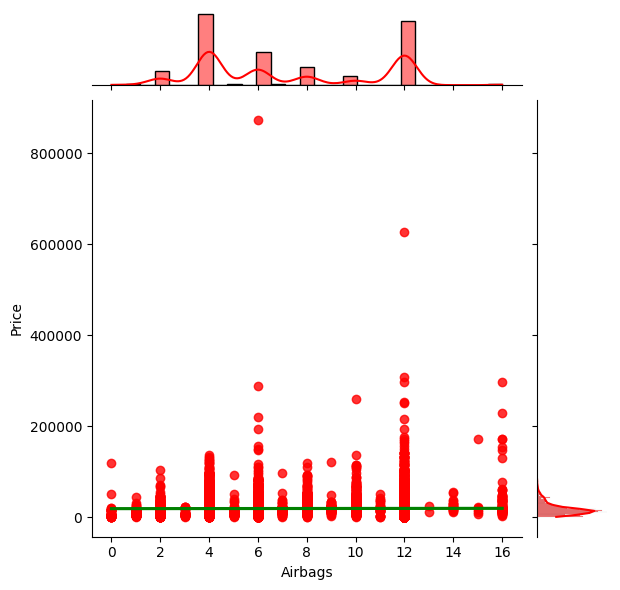

In [39]:
sns.jointplot(data=df, x='Airbags', y='Price', kind='reg', color='red', line_kws={'color': 'green'})
plt.show()

### Analysing the "Engine Volume' Column

In [40]:
# 1. FIRST: Create the 'Engine Type' column using the original string values
df['Engine Type'] = df['Engine volume'].apply(lambda x: 1 if 'Turbo' in str(x) else 0)

# 2. SECOND: Now clean the 'Engine volume' column by removing 'Turbo' and converting# Split the string by space and take the first part, then convert to float
df['Engine volume'] = df['Engine volume'].str.split().str[0].astype(float)

In [41]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Store original data for comparison
original_engine_vol = df['Engine volume'].copy()

# Clean the data (properly)
df.loc[(df['Engine volume'] > 8) | (df['Engine volume'] < 0.6), 'Engine volume'] = np.nan

# Create subplots with dark theme
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Engine Volume Before Cleaning', 
                    'Engine Volume After Cleaning<br>(>8L values → NaN)')
)

# Add before cleaning boxplot
fig.add_trace(
    go.Box(y=original_engine_vol, name='Before', marker_color='cyan'),
    row=1, col=1
)

# Add after cleaning boxplot
fig.add_trace(
    go.Box(y=df['Engine volume'][df['Engine volume'].notna()], name='After', marker_color='lime'),
    row=1, col=2
)

# Update layout with dark theme
fig.update_layout(
    template='plotly_dark',
    title_text='Engine Volume Distribution: Before vs After Cleaning',
    title_x=0.5,
    font=dict(color='white'),
    showlegend=False,
    height=500
)

# Update y-axis labels
fig.update_yaxes(title_text='Liters', row=1, col=1)
fig.update_yaxes(title_text='Liters', row=1, col=2)

fig.show()

In [42]:
# Filling the missing values in # Group by 'Cylinders' and fill missing 'Engine volume' with the median of that group
df['Engine volume'] = df.groupby('Cylinders')['Engine volume'].transform(
    lambda x: x.fillna(x.mode())
)

# If there are any remaining NaNs (groups with no data), fill with overall median
df['Engine volume'] = df['Engine volume'].fillna(df['Engine volume'].mode())


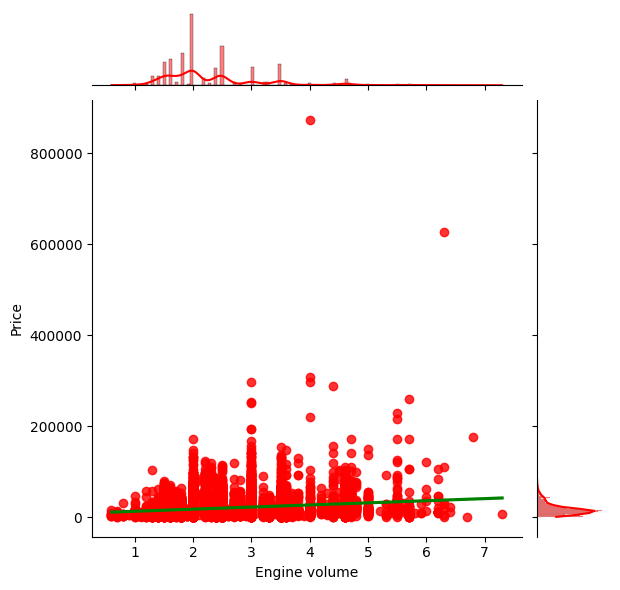

In [43]:
sns.jointplot(data=df, x='Engine volume', y='Price', kind='reg', color='red', line_kws={'color': 'green'})
plt.show()

In [ ]:
df

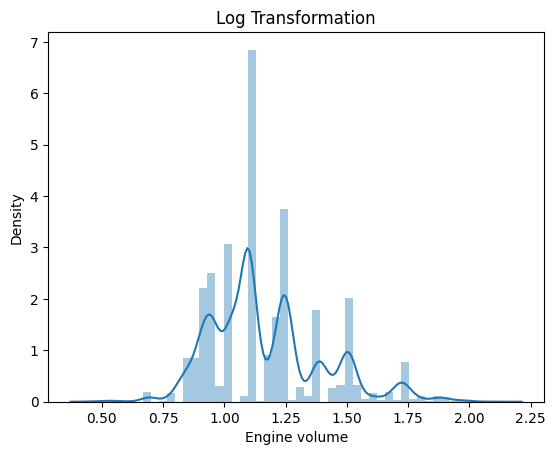

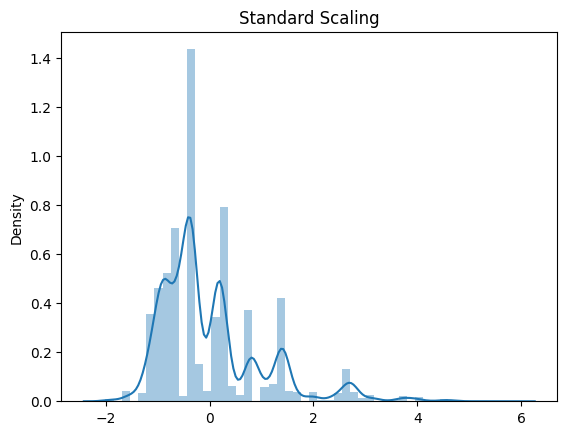

In [44]:
# Applying different type of transformation over the Engine volume column  to make it normal
from sklearn.preprocessing import power_transform, MinMaxScaler, StandardScaler

class ApplyTransformation:
    def __init__(self, x):
        self.x = x
        
    def apply_log(self):
        x_transformed = np.log1p(self.x)
        plt.figure()
        sns.distplot(x_transformed, kde=True)  # Using distplot
        plt.title('Log Transformation')
        plt.show()
        return x_transformed
    
    def apply_yeo_johnson(self):
        # Reshape for sklearn (2D array required)
        x_reshaped = self.x.values.reshape(-1, 1)
        x_transformed = power_transform(x_reshaped, method='yeo-johnson')
        x_transformed = x_transformed.flatten()  # Convert back to 1D
        
        plt.figure()
        sns.distplot(x_transformed, kde=True)  # Using distplot
        plt.title('Yeo-Johnson Transformation')
        plt.show()
        return x_transformed
    
    def apply_box_cox(self):
        # Check for positive values
        if (self.x <= 0).any():
            raise ValueError("Box-Cox transformation requires positive values")
            
        # Reshape for sklearn
        x_reshaped = self.x.values.reshape(-1, 1)
        x_transformed = power_transform(x_reshaped, method='box-cox')
        x_transformed = x_transformed.flatten()
        
        plt.figure()
        sns.distplot(x_transformed, kde=True)  # Using distplot
        plt.title('Box-Cox Transformation')
        plt.show()
        return x_transformed
    
    def min_max_scaler(self):
        # Reshape for sklearn
        x_reshaped = self.x.values.reshape(-1, 1)
        scaler = MinMaxScaler()
        x_transformed = scaler.fit_transform(x_reshaped)
        x_transformed = x_transformed.flatten()
        
        plt.figure()
        sns.distplot(x_transformed, kde=True)  # Using distplot
        plt.title('Min-Max Scaling')
        plt.show()
        return x_transformed
    
    def standard_scaler(self):
        # Reshape for sklearn
        x_reshaped = self.x.values.reshape(-1, 1)
        scaler = StandardScaler()
        x_transformed = scaler.fit_transform(x_reshaped)
        x_transformed = x_transformed.flatten()
        
        plt.figure()
        sns.distplot(x_transformed, kde=True)  # Using distplot
        plt.title('Standard Scaling')
        plt.show()
        return x_transformed
        
        
# Create transformer instance
transformer = ApplyTransformation(df['Engine volume'])

# Apply transformations
log_transformed = transformer.apply_log()
standardized = transformer.standard_scaler()
     
    

    
    
    

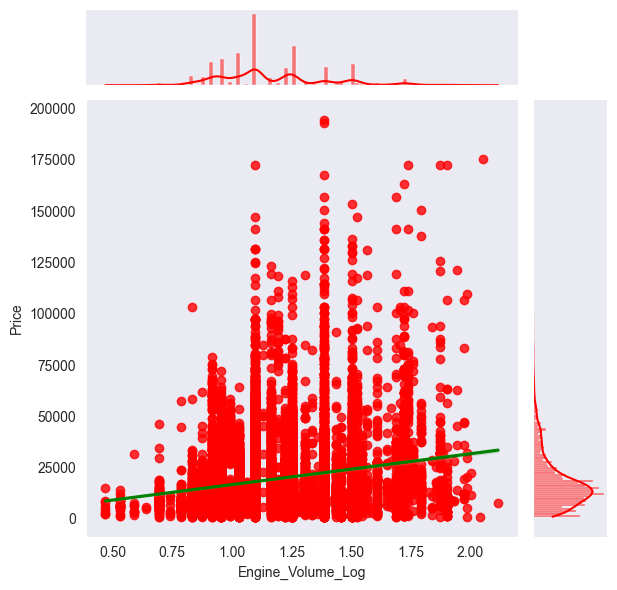

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Apply log transformation to engine volume
df['Engine_Volume_Log'] = np.log1p(df['Engine volume'])

# Check the new relationship
sns.jointplot(data=df, x='Engine_Volume_Log', y='Price', kind='reg', color='red', line_kws={'color': 'green'})
plt.show()

In [62]:
df['Engine volume'].describe()

count    19237.000000
mean         2.311150
std          0.853073
min          0.600000
25%          1.800000
50%          2.000000
75%          2.500000
max          7.300000
Name: Engine volume, dtype: float64

In [64]:
df.columns

Index(['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'year', 'Category',
       'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Airbags', 'Engine Type'],
      dtype='object')

In [ ]:
# Making the Gear Type column more to numerical using one-hot encoding
df = pd.get_dummies(df, columns=['Gear box type'], drop_first=False)

df = df.astype({col: 'int' for col in df.filter(like='Gear box type').columns})     # Makes the one-hot encoded columns to int type

### Cleaning the 'Leather interior' column 

In [66]:
# Converting the 'Leather interior' column to binary
df['Leather interior'] = df['Leather interior'].apply(lambda x: 1 if x == 'Yes' else 0)

### Working with the Driver Wheel column

In [ ]:
# Map the type values into more redable way
drive_wheel_mapping = {
    '4x4': '4WD',
    'Front': 'FWD',
    'Rear': 'RWD'
}

df['Drive wheels'] = df['Drive wheels'].replace(drive_wheel_mapping)

# Applying the one- hot encoding
df = pd.get_dummies(df, columns=['Drive wheels'], drop_first=False)

df = df.astype({col: 'int' for col in df.filter(like='Drive wheels').columns})     # Makes the one-hot encoded columns to int type

### Cleaning the mileage column

In [54]:
# Cleaning the 'Mileage' column by removing 'km' and converting to integer
df['Mileage'] = df['Mileage'].str.replace('km', '').str.replace(',', '').astype(int)

# Count how many rows have the absurd maximum value
absurd_value = 2147483647
absurd_count = (df['Mileage'] == absurd_value).sum()
print(f"Number of rows with absurd mileage ({absurd_value}): {absurd_count}")
print(f"Percentage of total data: {(absurd_count / len(df)) * 100:.2f}%")

# Also, check for other very high values (e.g., over 1,000,000 km)
unreal_mileage = (df['Mileage'] < 100) | (df['Mileage'] > 500000).sum()
print(f"Number of rows with unrealistic mileage: {unreal_mileage}")
original_shape = df.shape

df.loc[(df['Mileage'] < 100) | (df['Mileage'] > 500000), 'Mileage'] = np.nan

print(f"Shape before cleaning: {original_shape}")
print(f"Shape after cleaning: {df.shape}")  # The shape should be THE SAME
print(f"Number of unrealistic mileage values converted to NaN: {df['Mileage'].isna().sum()}")

Number of rows with absurd mileage (2147483647): 7
Percentage of total data: 0.04%
Number of rows with unrealistic mileage: 0        True
1        True
2        True
3        True
4        True
         ... 
19232    True
19233    True
19234    True
19235    True
19236    True
Name: Mileage, Length: 19224, dtype: bool
Shape before cleaning: (19224, 17)
Shape after cleaning: (19224, 17)
Number of unrealistic mileage values converted to NaN: 982


In [55]:
df['Mileage'].isna().sum(
    
)

np.int64(982)

In [56]:
# Group by relevant columns and fill NaN with the mode (most common value) of that group
df['Mileage'] = df.groupby(['Engine volume', 'Cylinders', 'Gear type_Manual', 'Gear type_Tiptronic', 'Gear type_Variator', 'Engine Type'])['Mileage'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna(df['Mileage'].mode()[0])
)

# Check if there are any remaining NaNs and fill with overall mode
if df['Mileage'].isna().sum() > 0:
    overall_mode = df['Mileage'].mode()
    if not overall_mode.empty:
        df['Mileage'] = df['Mileage'].fillna(overall_mode[0])

In [57]:
        
df['Mileage'].isna().sum()

np.int64(0)

<Axes: xlabel='Mileage', ylabel='Density'>

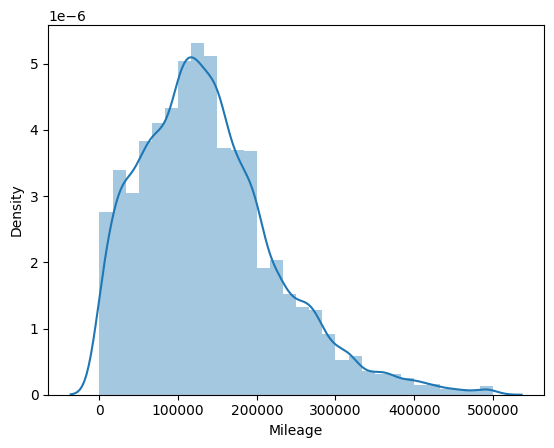

In [58]:
sns.distplot(df['Mileage'], bins=30, kde=True)

### Analysing the cylinder column 

In [59]:
df[df['Cylinders'] < 3]['Cylinders'] = np.nan
print(f"Number of rows with unrealistic 'Cylinders' values (<3): {df['Cylinders'].isna().sum()}")

# Applying the same technique as applied to the 'Mileage' column to fill these unusual 'Cylinders' values
df['Cylinders'] = df.groupby(['Engine volume', 'Gear type_Manual', 'Gear type_Tiptronic', 'Gear type_Variator', 'Engine Type'])['Cylinders'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna(df['Cylinders'].mode()[0])
)

Number of rows with unrealistic 'Cylinders' values (<3): 0


<Axes: xlabel='Cylinders', ylabel='Density'>

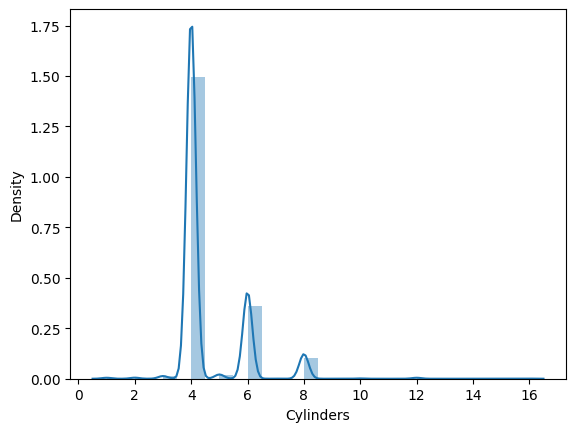

In [60]:
sns.distplot(df['Cylinders'], bins=30, kde=True)

## Data Pre-Processing 

In [61]:
df.columns

Index(['Price', 'Levy', 'year', 'Category', 'Leather interior', 'Fuel type',
       'Engine volume', 'Mileage', 'Cylinders', 'Wheel', 'Color', 'Airbags',
       'Engine Type', 'Gear type_Automatic', 'Gear type_Manual',
       'Gear type_Tiptronic', 'Gear type_Variator'],
      dtype='object')

#### Working on the target column

In [62]:
df['Price'].describe()

count     19224.000000
mean      18957.058261
std       16222.019883
min        1000.000000
25%        9565.000000
50%       15053.000000
75%       22063.000000
max      194438.000000
Name: Price, dtype: float64

In [65]:
df.columns

Index(['Price', 'Levy', 'year', 'Category', 'Leather interior', 'Fuel type',
       'Engine volume', 'Mileage', 'Cylinders', 'Wheel', 'Color', 'Airbags',
       'Engine Type', 'Gear type_Automatic', 'Gear type_Manual',
       'Gear type_Tiptronic', 'Gear type_Variator'],
      dtype='object')

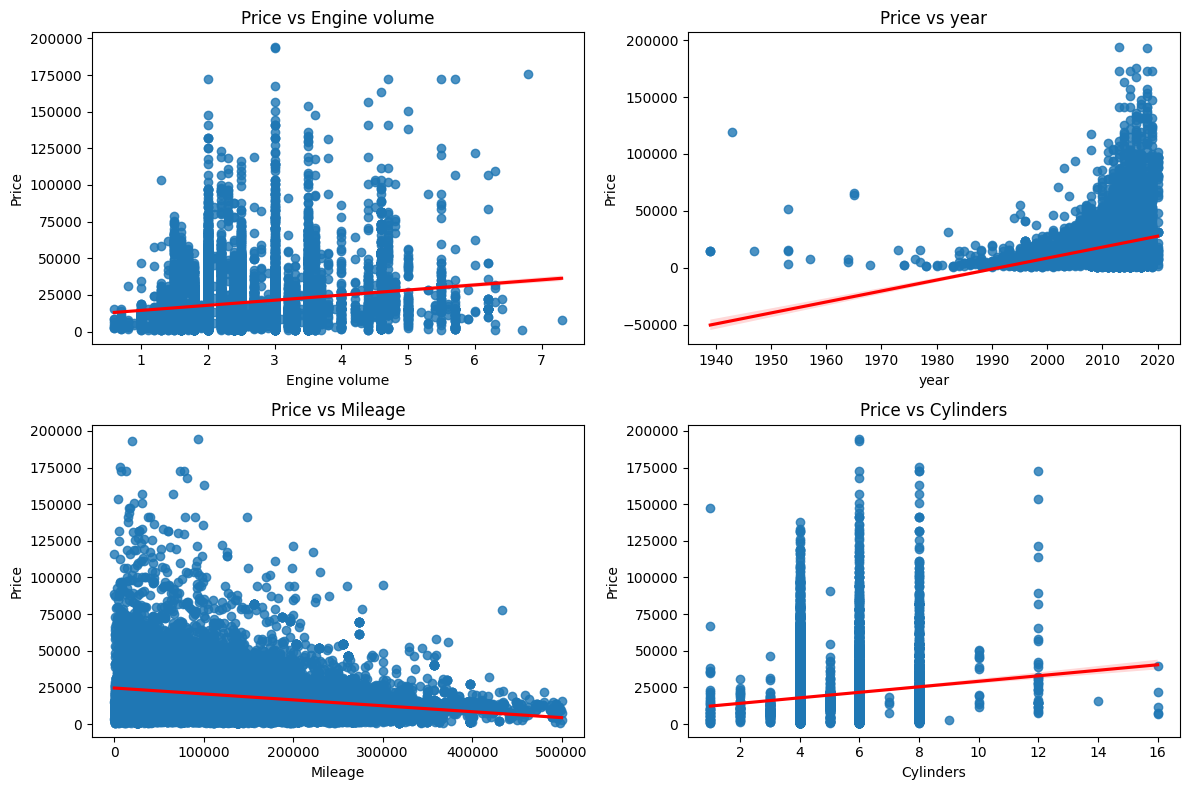

In [70]:
cols = ["Engine volume", "year", "Mileage", "Cylinders"]

# Create a grid: 2 rows, 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  

for ax, col in zip(axes.flatten(), cols):
    sns.regplot(data=df, x=col, y="Price", ax=ax, line_kws={"color": "red"})
    ax.set_title(f"Price vs {col}")

plt.tight_layout()
plt.show()


### Data Cleaning 

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots: 1 row, as many columns as categorical_cols
fig = make_subplots(rows=1, cols=len(categorical_cols),
                    subplot_titles=[f'{col}' for col in categorical_cols])

# Loop through categorical columns and add a subplot for each
for i, col in enumerate(categorical_cols):
    fig.add_trace(
        go.Bar(
            x=df[col].value_counts().index,
            y=df[col].value_counts().values
        ),
        row=1,
        col=i+1
    )

# Update layout
fig.update_layout(
    title='Distribution of Categorical Columns',
    template='plotly_dark',
    showlegend=False,
    width=400 * len(categorical_cols),   # 400px width per subplot
    height=500
)

fig.show()


#### Cleaning the levy column 

In [30]:
# Cleanign the leavy column & change the data type to int
df['Levy'] = df['Levy'].replace('-', np.nan)
df['Levy'] = df['Levy'].astype(float)

df['Levy'].isna().sum()

df['Levy_missing'] = df['Levy'].apply(lambda x: 1 if pd.isna(x) else 0)
df['Levy'].fillna(df['Levy'].median(), inplace=True)

# Plot the pltoly box plot to visualize outliers
fig = go.Figure()
fig.add_trace(go.Box(y=df['Levy'], name='Levy', boxpoints='outliers', jitter=0.5, pointpos=-1.8))
fig.update_layout(title='Box Plot of Levy', template='plotly_dark')
fig.show()

In [31]:
# Drop all the levy values over 5k
df.drop( df[df['Levy'] > 5000].index, inplace=True)

# Plot the pltoly box plot to visualize outliers
fig = go.Figure()
fig.add_trace(go.Box(y=df['Levy'], name='Levy', boxpoints='outliers', jitter=0.5, pointpos=-1.8))
fig.update_layout(title='Box Plot of Levy', template='plotly_dark')
fig.show()

In [32]:
Q3 = np.percentile(df['Levy'], 75)
IQR = np.percentile(df['Levy'], 75) - np.percentile(df['Levy'], 25)
upper_limit = Q3 + 1.5 * IQR
lower_limit = np.percentile(df['Levy'], 25) - 1.5 * IQR

percentile = np.sum(df['Levy'] > upper_limit) / len(df['Levy']) * 100
print(f'Percentage of data above the upper limit: {percentile:.2f}%')

# Create a flag column for the outliers 
df['Levy_flag'] = ~df['Levy'].between(lower_limit, upper_limit)

Percentage of data above the upper limit: 12.07%


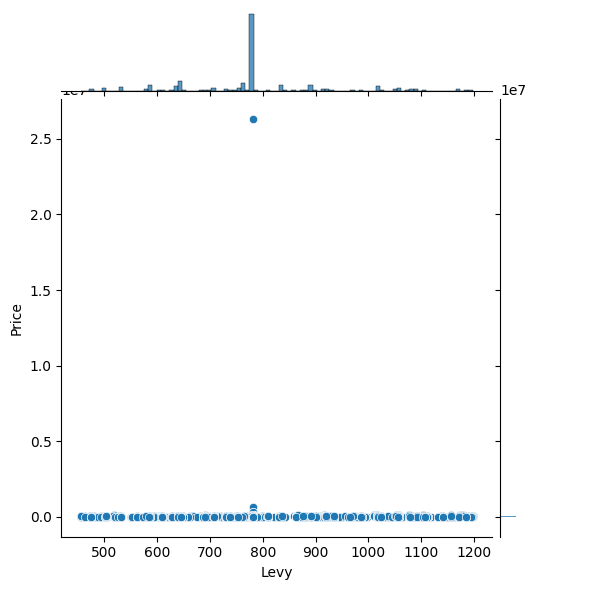

np.int64(26307500)

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

df_nf = df.loc[~df["Levy_flag"]].copy()

g = sns.jointplot(
    data=df_nf,
    x="Levy",
    y="Price",
    kind="scatter",       # or "hex", "kde", "reg"
    height=6,
    space=0.1
)
g.set_axis_labels("Levy", "Price")
plt.show()

df_nf['Price'].max()


In [8]:
df.head()

,ID,Price,Levy,Manufacturer,Model,year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear type,Wheel,Color,Airbags,Levy_missing
0,45654403,13328,1399.0,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6,Automatic,Left wheel,Silver,12,0
1,44731507,16621,1018.0,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6,Tiptronic,Left wheel,Black,8,0
2,45774419,8467,781.0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4,Variator,Right-hand drive,Black,2,0
3,45769185,3607,862.0,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4,Automatic,Left wheel,White,0,0
4,45809263,11726,446.0,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4,Automatic,Left wheel,Silver,4,0


In [11]:
# Cleaning the 'Mileage' column by removing 'km' and converting to integer
df['Mileage'] = df['Mileage'].str.replace('km', '').str.replace(',', '').astype(int)

In [ ]:
# Cleanig the 'Engine_volume' column by removing 'Turbo' and converting to integer
df['Engine_volume_value'] = df['Engine volume'].str.replace('Turbo', '').astype(float)
df['Enigine_type'] = df['Engine volume'].apply(lambda x: 'Turbo' if 'Turbo' in x else 'Non-Turbo')
df.drop('Engine volume', axis=1, inplace=True)

In [76]:
def remove_units(col):
    return str(col).split(' ')[0]  # Convert to string before splitting

def make_zero_nan(col):
    try:
        # First attempt to convert to integer
        int_val = int(col)
        # Return np.nan if zero, otherwise return the integer
        return np.nan if int_val == 0 else int_val
    except (ValueError, TypeError):
        # Return original value if conversion fails
        return col

def extract_types(col):
    if pd.isna(col):
        return (np.nan, np.nan)
    
    parts = str(col).split(' ')
    value = parts[0] if len(parts) > 0 else np.nan
    types = ' '.join(parts[1:]) if len(parts) > 1 else np.nan
    
    # Convert value to float if possible
    try:
        value = float(value)
    except (ValueError, TypeError):
        value = np.nan
        
    return (value, types)

def handle_hyphens(col):
    try:
        str_val = str(col).strip()  
        
        if str_val == '-':
            return np.nan
            
        return float(str_val)
    except (ValueError, TypeError):
        return np.nan  

### EDA 

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from warnings import filterwarnings
filterwarnings('ignore')

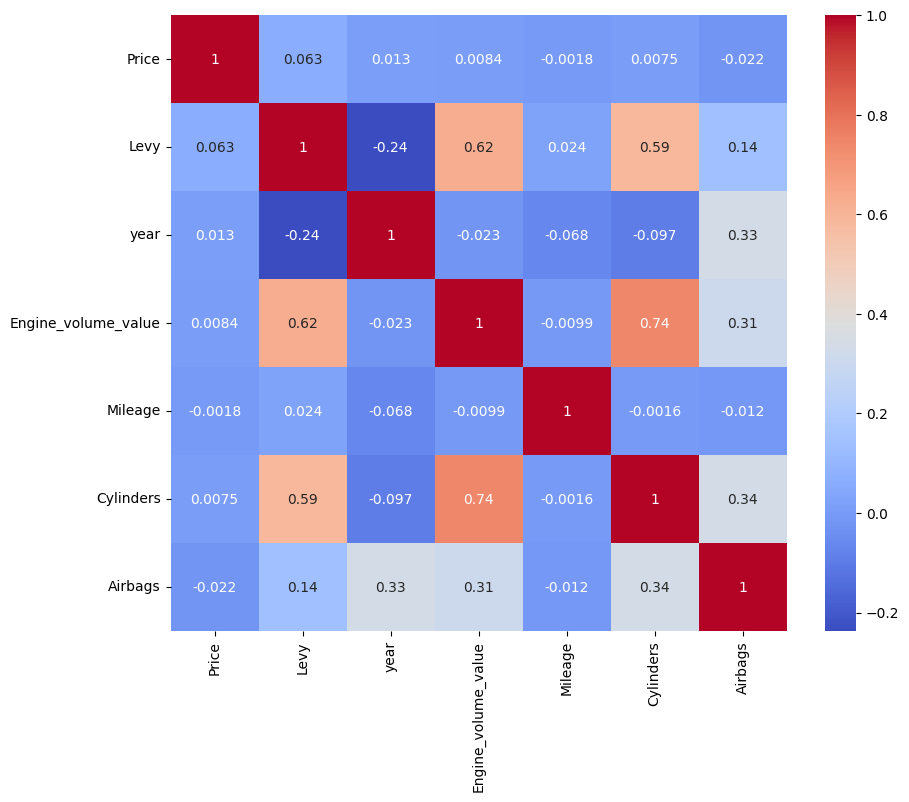

In [83]:
# calculate the correlation matrix
corr_matrix = df[numerical_cols].corr()

# create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)

# show the plot
plt.show()

##### Analysing the price column

In [84]:
df = df[(df['Price'] >= 2000) & (df['Price'] <= 500000)]

In [92]:
# Create subplots: 1 row, 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("Box Plot", "PDF Plot"))

# Box plot
fig.add_trace(
    go.Box(
        x=df["Price"],
        boxpoints="outliers",  # Show outliers
        hoverinfo="text",
        hovertext=[f"Price: {price}" for price in df["Price"]]
    ),
    row=1, col=1
)

# Histogram (PDF-like plot)
fig.add_trace(
    go.Histogram(
        x=df["Price"],
        nbinsx=50
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title="Distribution of Price",
    template="plotly_dark"
)

fig.show()


In [87]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

outliers = (df['Price'] < (Q1 - 1.5 * IQR)) | (df['Price'] > (Q3 + 1.5 * IQR))
print(Q1, Q3, IQR)

9408.0 24920.0 15512.0
